In [ ]:
"""
*Uncomment if running on colab* 
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab 
"""
# !git clone https://github.com/anuj27596/image-restoration
# !mv image-restoration/* ./

# Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Model
from skimage.transform import rescale
import matplotlib.pyplot as plt
import numpy as np
import cv2
from model import get_Model
import time
from rrmse import rrmse
import random as python_random

tf.random.set_seed(100)
np.random.seed(1)
python_random.seed(123)

print(tf.__version__)

import os

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

0.2721655269759087
2.3.0-dev20200618


In [2]:
class BMCallback(Callback):
	def __init__(self):
		self.best_weights = None
		self.min_loss = 1

	def on_epoch_end(self, epoch, logs=None):
		if logs['loss'] < self.min_loss:
			self.min_loss = logs['loss']
			self.best_weights = self.model.get_weights()

def mse_masked(mask):
	def loss_func(y_true, y_pred):
		return K.mean(K.square((y_pred - y_true) * mask))
	return loss_func

def rrmse_gr(gr):
	def loss_func(y_true, y_pred):
		return K.sqrt(K.sum(K.square(y_pred - gr))/K.sum(K.square(gr)))
	return loss_func

def scaled_loss(scale_exp):
	def loss_func(y_true, y_pred):
		s = 2**scale_exp
		down_ypred = y_pred[:,::s,::s] * 0
		for i in range(s):
			for j in range(s):
				down_ypred = down_ypred + y_pred[:, i::s, j::s]
		down_ypred = down_ypred / s**2

		mse = K.mean(K.square(y_true - down_ypred))
		var = K.mean(K.square(y_pred[:,1:,:] - y_pred[:,:-1,:])) + K.mean(K.square(y_pred[:,:,1:] - y_pred[:,:,:-1]))
		return mse + var/12
	return loss_func




# Cat Text Removal

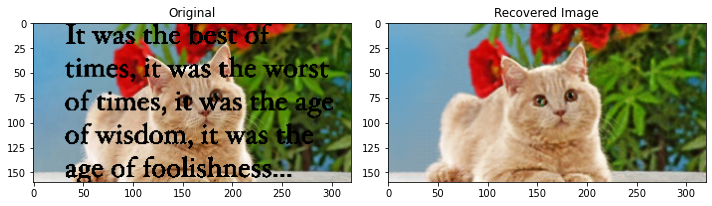

In [3]:
cat_img = plt.imread('data/cat.png')[:,:,:3]
M, N, C = cat_img.shape

mask = (np.sum(cat_img, axis=2) > 0).reshape(M, N, 1)	# pixels of text are (0,0,0) (black)

F = 16

model = get_Model(Input((M, N, F)), n_filters=16, depth=4, output_channels=C)
model.compile(optimizer=Adam(), loss=mse_masked(mask))


z = np.random.uniform(low=-1, high=1, size=(1,M,N,F))

bmcb = BMCallback()

hist = model.fit(z, cat_img.reshape((1,M,N,C)), epochs=2000, verbose=0, callbacks=[bmcb])
model.set_weights(bmcb.best_weights)


rec_cat_img = model.predict(z)[0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1.set_title("Original")
ax1.imshow(cat_img)
ax2.set_title("Recovered Image")
ax2.imshow(rec_cat_img)
fig.tight_layout()
plt.show()

# MRI Inpainting

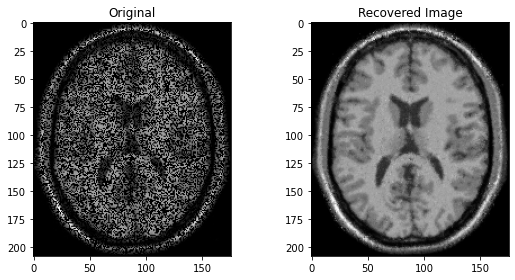

In [5]:
mri_img = plt.imread('data/brain_mri.png')
M, N = mri_img.shape
mri_img = mri_img.reshape((M,N,1))
mask = np.random.uniform(size=(M,N,1)) > 0.5

img = mri_img * mask

F = 16

model = get_Model(Input((M, N, F)), n_filters=16, depth=4, output_channels=1)
model.compile(optimizer=Adam(), loss=mse_masked(mask))

np.random.seed(2)
z = np.random.uniform(low=-1, high=1, size=(1,M,N,F))

bmcb = BMCallback()

hist = model.fit(z, img.reshape((1,M,N,1)), epochs=1800, verbose=0, callbacks=[bmcb])
model.set_weights(bmcb.best_weights)

rec_img = model.predict(z)[0,:,:,0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.set_title("Original")
ax1.imshow(img[:, :, 0], cmap='gray')
ax2.set_title("Recovered Image")
ax2.imshow(rec_img, cmap='gray')
fig.tight_layout()

plt.show()

# MRI Denoising

In [3]:
def denoise(noiseless_img_path, noisy_img_path, lr, epochs, depth=4):
	nl_img = plt.imread(noiseless_img_path)
	noisy_img = plt.imread(noisy_img_path)
	
	if len(nl_img.shape) == 3:
		M, N, C = nl_img.shape
	else:
		M, N = nl_img.shape
		C = 1
	
	Mp = (M//(2**depth) + 1)*(2**depth)
	Np = (N//(2**depth) + 1)*(2**depth)
	x = (Np-N)
	y = (Mp-M)
	noisy_imgp = cv2.copyMakeBorder(noisy_img.copy(),0,y,0,x,cv2.BORDER_CONSTANT,value=[0,0,0])
	nl_imgp = cv2.copyMakeBorder(nl_img.copy(),0,y,0,x,cv2.BORDER_CONSTANT,value=[0,0,0])
	
	noisy_imgp = noisy_imgp.reshape((Mp, Np, C))
	nl_imgp = nl_imgp.reshape((Mp, Np, C))

	F = 16

	z = np.random.uniform(low=-1, high=1, size=(1,Mp,Np,F))


	model = get_Model(Input((Mp, Np, F)), n_filters=8, depth=depth, output_channels=C)
	model.compile(optimizer=Adam(lr=lr), loss='mse', metrics=[rrmse_gr(nl_imgp)])
	hist = model.fit(z, noisy_imgp.reshape((1,Mp,Np,C)), epochs=epochs, verbose=0)
	rec_img = model.predict(z)[0]
	
	if C == 1:
		rec_img = rec_img[:M, :N, 0]
	else:
		rec_img = rec_img[:M, :N, :]
	
	return nl_img, noisy_img, rec_img


Text(0, 0.5, 'Recovered Images')

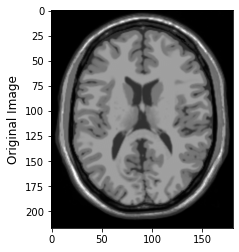

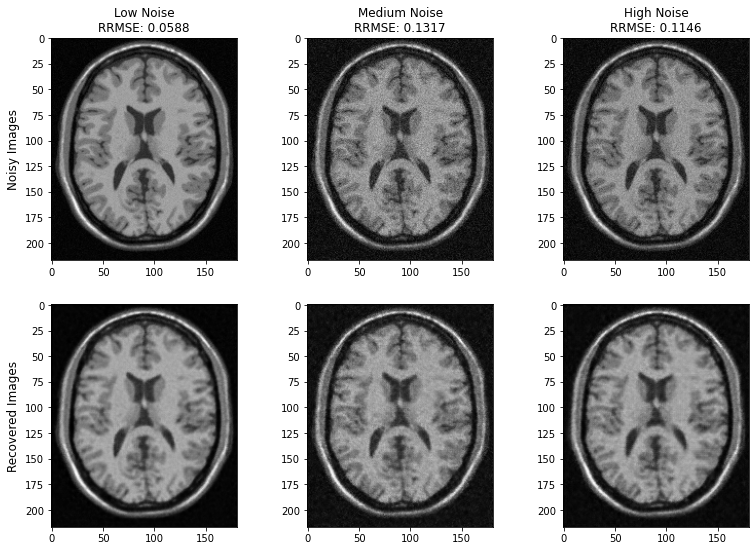

In [4]:
nl_img_path = 'data/mri_image_noiseless.png'
low_noise_img_path = 'data/mri_image_noise_level_low.png'
med_noise_img_path = 'data/mri_image_noise_level_medium.png'
high_noise_img_path = 'data/mri_image_noise_level_high.png'
noisy_img_paths = [low_noise_img_path, high_noise_img_path, med_noise_img_path]
titles = ['Low Noise', 'Medium Noise', 'High Noise']
lrs = [0.001, 0.001, 0.001]
epochs = [1400, 1200, 1100]

start = 0                       # modify these to recover particular set of images
end = len(noisy_img_paths)

noisy_imgs = []
rec_imgs = []
title_imgs = []
for i in range(start, end):
	nl_mri_img, noisy_mri_img, rec_mri_img = denoise(nl_img_path, noisy_img_paths[i], lrs[i], epochs[i])
	noisy_imgs.append(noisy_mri_img)
	rec_imgs.append(rec_mri_img)
	title_imgs.append(titles[i])

plt.imshow(nl_mri_img, cmap='gray')
plt.ylabel('Original Image', size='large', labelpad=5)

fig, axes = plt.subplots(2, end-start, figsize=(13, 9))
axes = axes.reshape((2, end-start))
for i in range(0, end-start):
	axes[0, i].imshow(noisy_imgs[i], cmap='gray')
	axes[1, i].imshow(rec_imgs[i], cmap='gray')
	axes[0, i].set_title(title_imgs[i]+f'\nRRMSE: {rrmse(nl_mri_img, rec_imgs[i]):.4f}')

axes[0, 0].set_ylabel('Noisy Images',  size='large', labelpad=5)
axes[1, 0].set_ylabel('Recovered Images', size='large', labelpad=5)

# Denoising Histology

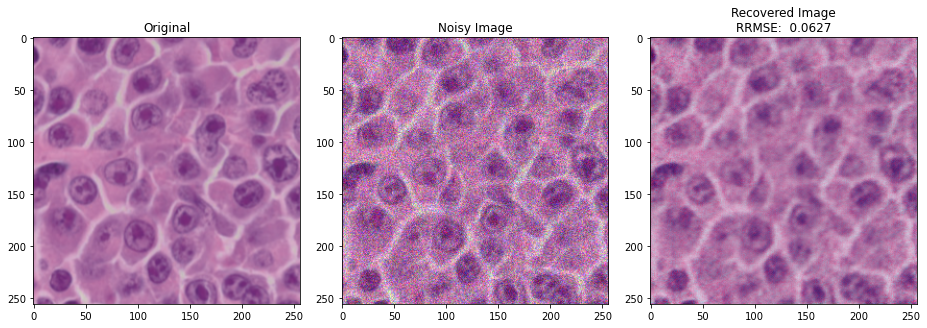

In [4]:
nl_histology_img_path = 'data/histology_noiseless.png'
noisy_histology_img_path = 'data/histology_noisy.png'

nl_hist_img, noisy_hist_img, rec_hist_img = denoise(nl_histology_img_path, noisy_histology_img_path, lr=0.0003, epochs=1600)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 8))

ax1.set_title("Original")
ax1.imshow(nl_hist_img)
ax2.set_title("Noisy Image")
ax2.imshow(noisy_hist_img)
ax3.set_title(f"Recovered Image\nRRMSE: {rrmse(nl_hist_img, rec_hist_img): 0.4f}")
ax3.imshow(rec_hist_img)
fig.tight_layout()


# Denoising Car

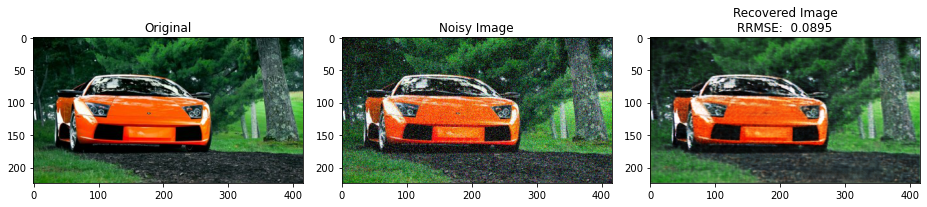

In [5]:
nl_car_img = plt.imread('data/car.png')
M, N, C = nl_car_img.shape
sigma = 0.1
noisy_car_img = nl_car_img + sigma * np.random.randn(M, N, C)
noisy_car_img = np.vectorize(lambda x: 1.0 if x>1 else 0.0 if x<0 else x)(noisy_car_img)

F = 16

model = get_Model(Input((M, N, F)), n_filters=8, depth=4, output_channels=C)
model.compile(optimizer=Adam(), loss='mse', metrics=[rrmse_gr(nl_car_img)])

np.random.seed(2)
z = np.random.uniform(low=-1, high=1, size=(1,M,N,F))

model.fit(z, noisy_car_img.reshape((1,M,N,C)), epochs=1600, verbose=0)

rec_car_img = model.predict(z)[0]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 8))

ax1.set_title("Original")
ax1.imshow(nl_car_img)
ax2.set_title("Noisy Image")
ax2.imshow(noisy_car_img)
ax3.set_title(f"Recovered Image\nRRMSE: {rrmse(nl_car_img, rec_car_img): 0.4f}")
ax3.imshow(rec_car_img)
fig.tight_layout()


# Super Resolution

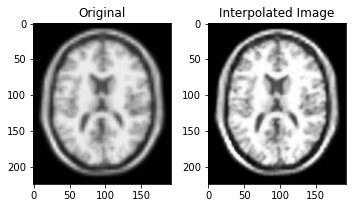

In [6]:
mri_img = np.zeros((56,48))
mri_img[2:-2,2:-2] = plt.imread('data/mri_lowres.png')
M, N = mri_img.shape
F = 16

model = get_Model(Input((M, N, F)), n_filters=16, depth=3, res_exp=2, output_channels=1)
model.compile(optimizer=Adam(), loss=scaled_loss(2))

z = np.random.uniform(low=-1, high=1, size=(1,M,N,F))

bmcb = BMCallback()

hist = model.fit(z, mri_img.reshape((1,M,N,1)), epochs=3000, verbose=0, callbacks=[bmcb])
model.set_weights(bmcb.best_weights)

rec_highres_mri_img = model.predict(z)[0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 3))

ax1.set_title("Original")
from skimage.transform import resize
ax1.imshow(resize(mri_img, (4*M, 4*N)), cmap='gray')
ax2.set_title("Interpolated Image")
ax2.imshow(rec_highres_mri_img[:,:,0], cmap='gray')
fig.tight_layout()

plt.show()

In [ ]:
plt.imsave('recovered_images/cat.png', rec_cat_img)
plt.imsave('recovered_images/mri_inpainting.png', rec_img, cmap='gray')
plt.imsave('recovered_images/mri_low_noise.png', rec_imgs[0], cmap='gray')
plt.imsave('recovered_images/mri_medium_noise.png', rec_imgs[0], cmap='gray')
plt.imsave('recovered_images/mri_high_noise.png', rec_imgs[0], cmap='gray')
plt.imsave('recovered_images/histology.png', rec_hist_img)
plt.imsave('recovered_images/mri_superres.png', rec_highres_mri_img[:,:,0], cmap='gray')
plt.imsave('recovered_images/car.png', rec_car_img)